In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import scipy.optimize as optimize

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

import itertools

from IPython.display import display

from eis.EISDataIO import eis_dataframe_from_csv

from os import path
import logging

In [2]:
from dataclasses import dataclass

@dataclass
class PointOfInterest:
    x: float
    y: float
    kind: str

In [4]:
# loading training data

# if you are on a windows machine un-comment the following line to get the path to training data
# here = !echo %cd%

# if you are on a mac/ unix machine un-comment the following line to get the path to training data
here = !pwd

train_data_path = path.join(path.dirname(here[0]), "train_data.csv")
eis_data = eis_dataframe_from_csv(train_data_path)

In [5]:
def complex_parts(cmp: pd.Series) -> tuple[pd.Series, pd.Series]:
    real_part= cmp.apply(np.real)
    imag_part= cmp.apply(np.imag)
    return (real_part, imag_part)

eis_data["Z_real"], eis_data["Z_imag"] = complex_parts(eis_data.Z)
display(eis_data)

,freq,Z,Circuit,Parameters,Z_real,Z_imag
0,"[0.1, 0.148398179, 0.220220195, 0.326802759, 0...","[(309.82561192-156.06088233j), (267.46983919-1...",L-R-RCPE-RCPE-RCPE,"L1: 2.94e-08, R1: 4.51e+00, R2: 5.19e-02, CPE1...","[309.82561192, 267.46983919, 229.38061493, 196...","[-156.06088233, -146.21033646, -133.4855237, -..."
1,"[1.0, 1.34339933, 1.80472177, 2.42446202, 3.25...","[(344.50700012-0.87321496j), (344.36191597-0.9...",RC-RC-RCPE-RCPE,"R1: 2.08e+02, R2: 2.50e+01, R3: 9.57e+01, R4: ...","[344.50700012, 344.36191597, 344.19647198, 344...","[-0.87321496, -0.99738889, -1.13909869, -1.300..."
2,"[1.0, 1.26360956, 1.59670912, 2.01761691, 2.54...","[(3080.15920083-80.84202473j), (3071.83539583-...",L-R-RCPE-RCPE-RCPE,"L1: 3.35e-08, R1: 6.95e+01, R2: 7.49e+01, CPE1...","[3080.15920083, 3071.83539583, 3061.93812951, ...","[-80.84202473, -94.50641483, -110.36642266, -1..."
3,"[10.0, 13.4990445, 18.2224203, 24.5985264, 33....","[(930.93345951-0.0068507146j), (930.93327153-0...",L-R-RCPE,"L1: 8.43e-07, R1: 9.06e+01, R2: 8.40e+02, CPE1...","[930.93345951, 930.93327153, 930.93302176, 930...","[-0.0068507146, -0.00910185162, -0.0120927041,..."
4,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(405.07355219-0.0149508921j), (405.07110253-0...",RCPE-RCPE-RCPE,"R1: 1.03e+01, R2: 6.71e-01, R3: 3.94e+02, CPE1...","[405.07355219, 405.07110253, 405.06786553, 405...","[-0.0149508921, -0.0197551995, -0.026103215, -..."
...,...,...,...,...,...,...
7457,"[10.0, 13.4596032, 18.1160919, 24.383541, 32.8...","[(4953.31225754-4814.61138816j), (4269.4031861...",RCPE-RCPE,"R1: 2.47e+01, R2: 2.95e+05, CPE1_t: 9.41e-01, ...","[4953.31225754, 4269.40318615, 3680.28615178, ...","[-4814.61138816, -4165.41666719, -3601.4380483..."
7458,"[10.0, 12.6485522, 15.9985872, 20.2358965, 25....","[(73538.51000223-1776.24017654j), (73413.60429...",L-R-RCPE-RCPE-RCPE,"L1: 1.05e-08, R1: 2.81e+01, R2: 6.40e+01, CPE1...","[73538.51000223, 73413.60429656, 73304.9395675...","[-1776.24017654, -1592.10621049, -1461.6962630..."
7459,"[1.0, 1.34453288, 1.80776868, 2.43060443, 3.26...","[(82.1093149-51.12982215j), (72.40330299-47.29...",RCPE-RCPE-RCPE,"R1: 4.78e+00, R2: 8.77e-01, R3: 2.85e+02, CPE1...","[82.1093149, 72.40330299, 63.66501847, 55.8809...","[-51.12982215, -47.29789889, -43.31241432, -39..."
7460,"[0.01, 0.0134051824, 0.0179698915, 0.024088967...","[(32.37740171-5.15196774e-05j), (32.37740063-6...",RCPE-RCPE,"R1: 5.65e+00, R2: 2.67e+01, CPE1_t: 9.21e-01, ...","[32.37740171, 32.37740063, 32.3773992, 32.3773...","[-5.15196774e-05, -6.82381469e-05, -9.03818659..."


In [6]:
def drange(cmp: pd.Series) -> tuple[pd.Series, pd.Series]:
    min_= cmp.apply(np.min)
    max_= cmp.apply(np.max)
    return (min_, max_)

eis_data["freq_min"], eis_data["freq_max"] = drange(eis_data.freq)
eis_data["Z_real_min"], eis_data["Z_real_max"] = drange(eis_data.Z_real)
eis_data["Z_imag_min"], eis_data["Z_imag_max"] = drange(eis_data.Z_imag)
display(eis_data)

,freq,Z,Circuit,Parameters,Z_real,Z_imag,freq_min,freq_max,Z_real_min,Z_real_max,Z_imag_min,Z_imag_max
0,"[0.1, 0.148398179, 0.220220195, 0.326802759, 0...","[(309.82561192-156.06088233j), (267.46983919-1...",L-R-RCPE-RCPE-RCPE,"L1: 2.94e-08, R1: 4.51e+00, R2: 5.19e-02, CPE1...","[309.82561192, 267.46983919, 229.38061493, 196...","[-156.06088233, -146.21033646, -133.4855237, -...",0.10,100000.000,4.802034,309.825612,-156.060882,-0.369196
1,"[1.0, 1.34339933, 1.80472177, 2.42446202, 3.25...","[(344.50700012-0.87321496j), (344.36191597-0.9...",RC-RC-RCPE-RCPE,"R1: 2.08e+02, R2: 2.50e+01, R3: 9.57e+01, R4: ...","[344.50700012, 344.36191597, 344.19647198, 344...","[-0.87321496, -0.99738889, -1.13909869, -1.300...",1.00,100000.000,230.202174,344.507000,-43.334151,-0.873215
2,"[1.0, 1.26360956, 1.59670912, 2.01761691, 2.54...","[(3080.15920083-80.84202473j), (3071.83539583-...",L-R-RCPE-RCPE-RCPE,"L1: 3.35e-08, R1: 6.95e+01, R2: 7.49e+01, CPE1...","[3080.15920083, 3071.83539583, 3061.93812951, ...","[-80.84202473, -94.50641483, -110.36642266, -1...",1.00,1995262.310,146.222822,3080.159201,-860.278825,-4.597264
3,"[10.0, 13.4990445, 18.2224203, 24.5985264, 33....","[(930.93345951-0.0068507146j), (930.93327153-0...",L-R-RCPE,"L1: 8.43e-07, R1: 9.06e+01, R2: 8.40e+02, CPE1...","[930.93345951, 930.93327153, 930.93302176, 930...","[-0.0068507146, -0.00910185162, -0.0120927041,...",10.00,199526.231,916.677733,930.933460,-78.835912,-0.006851
4,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(405.07355219-0.0149508921j), (405.07110253-0...",RCPE-RCPE-RCPE,"R1: 1.03e+01, R2: 6.71e-01, R3: 3.94e+02, CPE1...","[405.07355219, 405.07110253, 405.06786553, 405...","[-0.0149508921, -0.0197551995, -0.026103215, -...",0.01,1995262.310,17.754399,405.073552,-120.693060,-0.014951
...,...,...,...,...,...,...,...,...,...,...,...,...
7457,"[10.0, 13.4596032, 18.1160919, 24.383541, 32.8...","[(4953.31225754-4814.61138816j), (4269.4031861...",RCPE-RCPE,"R1: 2.47e+01, R2: 2.95e+05, CPE1_t: 9.41e-01, ...","[4953.31225754, 4269.40318615, 3680.28615178, ...","[-4814.61138816, -4165.41666719, -3601.4380483...",10.00,100000.000,72.555800,4953.312258,-4814.611388,-48.358524
7458,"[10.0, 12.6485522, 15.9985872, 20.2358965, 25....","[(73538.51000223-1776.24017654j), (73413.60429...",L-R-RCPE-RCPE-RCPE,"L1: 1.05e-08, R1: 2.81e+01, R2: 6.40e+01, CPE1...","[73538.51000223, 73413.60429656, 73304.9395675...","[-1776.24017654, -1592.10621049, -1461.6962630...",10.00,1000000.000,952.937485,73538.510002,-25026.297801,-1347.863875
7459,"[1.0, 1.34453288, 1.80776868, 2.43060443, 3.26...","[(82.1093149-51.12982215j), (72.40330299-47.29...",RCPE-RCPE-RCPE,"R1: 4.78e+00, R2: 8.77e-01, R3: 2.85e+02, CPE1...","[82.1093149, 72.40330299, 63.66501847, 55.8809...","[-51.12982215, -47.29789889, -43.31241432, -39...",1.00,1995262.310,5.685886,82.109315,-51.129822,-0.082206
7460,"[0.01, 0.0134051824, 0.0179698915, 0.024088967...","[(32.37740171-5.15196774e-05j), (32.37740063-6...",RCPE-RCPE,"R1: 5.65e+00, R2: 2.67e+01, CPE1_t: 9.21e-01, ...","[32.37740171, 32.37740063, 32.3773992, 32.3773...","[-5.15196774e-05, -6.82381469e-05, -9.03818659...",0.01,100000.000,6.077507,32.377402,-12.515715,-0.000052


In [7]:
def minmaxer(cmp: pd.Series, min_, max_) -> pd.Series:
    minmaxed = (cmp-min_)/(max_-min_)
    return minmaxed

Z_real_min = eis_data["Z_real_min"].min()
Z_real_max = eis_data["Z_real_max"].max()
Z_imag_min = eis_data["Z_imag_min"].min()
Z_imag_max = eis_data["Z_imag_max"].max()
eis_data["Z_real_minmaxed"] = minmaxer(eis_data.Z_real,Z_real_min,Z_real_max)
eis_data["Z_imag_minmaxed"] = minmaxer(eis_data.Z_imag,Z_imag_min,Z_imag_max)
display(eis_data)

,freq,Z,Circuit,Parameters,Z_real,Z_imag,freq_min,freq_max,Z_real_min,Z_real_max,Z_imag_min,Z_imag_max,Z_real_minmaxed,Z_imag_minmaxed
0,"[0.1, 0.148398179, 0.220220195, 0.326802759, 0...","[(309.82561192-156.06088233j), (267.46983919-1...",L-R-RCPE-RCPE-RCPE,"L1: 2.94e-08, R1: 4.51e+00, R2: 5.19e-02, CPE1...","[309.82561192, 267.46983919, 229.38061493, 196...","[-156.06088233, -146.21033646, -133.4855237, -...",0.10,100000.000,4.802034,309.825612,-156.060882,-0.369196,"[0.0024010756884318006, 0.002387371182141883, ...","[0.9964493638297757, 0.9964559871114435, 0.996..."
1,"[1.0, 1.34339933, 1.80472177, 2.42446202, 3.25...","[(344.50700012-0.87321496j), (344.36191597-0.9...",RC-RC-RCPE-RCPE,"R1: 2.08e+02, R2: 2.50e+01, R3: 9.57e+01, R4: ...","[344.50700012, 344.36191597, 344.19647198, 344...","[-0.87321496, -0.99738889, -1.13909869, -1.300...",1.00,100000.000,230.202174,344.507000,-43.334151,-0.873215,"[0.0024122970939710123, 0.002412250150980291, ...","[0.9965537084667062, 0.9965536249749967, 0.996..."
2,"[1.0, 1.26360956, 1.59670912, 2.01761691, 2.54...","[(3080.15920083-80.84202473j), (3071.83539583-...",L-R-RCPE-RCPE-RCPE,"L1: 3.35e-08, R1: 6.95e+01, R2: 7.49e+01, CPE1...","[3080.15920083, 3071.83539583, 3061.93812951, ...","[-80.84202473, -94.50641483, -110.36642266, -1...",1.00,1995262.310,146.222822,3080.159201,-860.278825,-4.597264,"[0.003297436482895553, 0.003294743257612999, 0...","[0.9964999392686594, 0.99649075164539, 0.99648..."
3,"[10.0, 13.4990445, 18.2224203, 24.5985264, 33....","[(930.93345951-0.0068507146j), (930.93327153-0...",L-R-RCPE,"L1: 8.43e-07, R1: 9.06e+01, R2: 8.40e+02, CPE1...","[930.93345951, 930.93327153, 930.93302176, 930...","[-0.0068507146, -0.00910185162, -0.0120927041,...",10.00,199526.231,916.677733,930.933460,-78.835912,-0.006851,"[0.0026020394734222194, 0.0026020394125999763,...","[0.9965542909902029, 0.9965542894765899, 0.996..."
4,"[0.01, 0.0148907532, 0.0221734532, 0.033017942...","[(405.07355219-0.0149508921j), (405.07110253-0...",RCPE-RCPE-RCPE,"R1: 1.03e+01, R2: 6.71e-01, R3: 3.94e+02, CPE1...","[405.07355219, 405.07110253, 405.06786553, 405...","[-0.0149508921, -0.0197551995, -0.026103215, -...",0.01,1995262.310,17.754399,405.073552,-120.693060,-0.014951,"[0.0024318938251909356, 0.002431893032586322, ...","[0.9965542855438289, 0.9965542823135225, 0.996..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7457,"[10.0, 13.4596032, 18.1160919, 24.383541, 32.8...","[(4953.31225754-4814.61138816j), (4269.4031861...",RCPE-RCPE,"R1: 2.47e+01, R2: 2.95e+05, CPE1_t: 9.41e-01, ...","[4953.31225754, 4269.40318615, 3680.28615178, ...","[-4814.61138816, -4165.41666719, -3601.4380483...",10.00,100000.000,72.555800,4953.312258,-4814.611388,-48.358524,"[0.003903508245800251, 0.003682224685933619, 0...","[0.9933170610547427, 0.9937535647319029, 0.994..."
7458,"[10.0, 12.6485522, 15.9985872, 20.2358965, 25....","[(73538.51000223-1776.24017654j), (73413.60429...",L-R-RCPE-RCPE-RCPE,"L1: 1.05e-08, R1: 2.81e+01, R2: 6.40e+01, CPE1...","[73538.51000223, 73413.60429656, 73304.9395675...","[-1776.24017654, -1592.10621049, -1461.6962630...",10.00,1000000.000,952.937485,73538.510002,-25026.297801,-1347.863875,"[0.02609472831582521, 0.026054314201793743, 0....","[0.9953599923411647, 0.9954837998070524, 0.995..."
7459,"[1.0, 1.34453288, 1.80776868, 2.43060443, 3.26...","[(82.1093149-51.12982215j), (72.40330299-47.29...",RCPE-RCPE-RCPE,"R1: 4.78e+00, R2: 8.77e-01, R3: 2.85e+02, CPE1...","[82.1093149, 72.40330299, 63.66501847, 55.8809...","[-51.12982215, -47.29789889, -43.31241432, -39...",1.00,1995262.310,5.685886,82.109315,-51.129822,-0.082206,"[0.002327396489029139, 0.0023242560410406555, ...","[0.9965199170738753, 0.9965224935714031, 0.996..."
7460,"[0.01, 0.0134051824, 0.0179698915, 0.024088967...","[(32.37740171-5.15196774e-05j), (32.37740063-6...",RCPE-RCPE,"R1: 5.65e+00, R2: 2.67e+01, CPE1_t: 9.21e-01, ...","[32.37740171, 32.37740063, 32.3773992, 32.3773...","[-5.15196774e-05, -6.82381469e-05,

In [8]:
def numerical_derivative(x: np.array, y: np.array) -> np.array:
    assert x.shape == y.shape
    dy = np.gradient(y)
    dx = np.gradient(x)
    der = dy/dx
    return der

In [9]:
numerical_derivative(eis_data["Z_real"][0], eis_data["Z_imag"][0])

array([-0.23256678, -0.28063098, -0.37935006, -0.47302795, -0.55940216,
       -0.63553828, -0.69759868, -0.74055315, -0.75804475, -0.74303396,
       -0.69034904, -0.60194096, -0.49263304, -0.38950968, -0.32061275,
       -0.30143706, -0.33170938, -0.40188199, -0.5003604 , -0.61689637,
       -0.74304453, -0.87169552, -0.9967766 , -1.11332491, -1.21772951,
       -1.3078858 , -1.38312941, -1.44396684, -1.49170568, -1.52809484,
       -1.55504783, -1.5744807 , -1.5882713 , -1.59834825, -1.60694408,
       -1.61176835])

In [10]:
def nth_derivatives(x: np.array, y: np.array, n: int = 1) -> list[np.array]:
    this_der = y
    res = [this_der]
    for i in range(n):
        nth = i+1
        this_der = numerical_derivative(x, this_der)
        res.append(this_der)
    return res

In [83]:
def plot_derivatives(
    x: np.array,
    derivatives: list[np.array],
    color_data: np.array,
    *,
    title: str=None,
    suptitle: str=None,
    interesting_points: list[PointOfInterest] = None
):
    fig, ax = plt.subplots(len(derivatives), 1, sharex=True)
    for i, d in enumerate(derivatives):
        ax[i].scatter(x,-d, c=color_data, cmap="viridis", norm=colors.LogNorm())
        if interesting_points is not None and i == 0:
            interesting_x = [p.x for p in interesting_points]
            interesting_y = [-p.y for p in interesting_points]
            ax[i].scatter(interesting_x,interesting_y, c="red")
        if title is not None:
            ax[i].set_title(title)
    if suptitle is not None:
        fig.suptitle(suptitle)
    

In [84]:
ders = nth_derivatives(eis_data["Z_real"][0], eis_data["Z_imag"][0], 2)

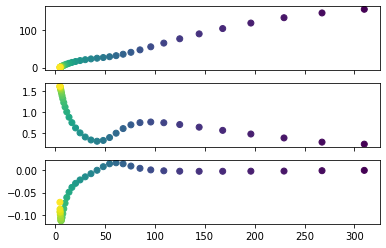

In [85]:
plot_derivatives(eis_data["Z_real"][0], ders, eis_data["freq"][0])

for n, g in eis_data.groupby("Circuit"):
    sample = g.sample(5)
    for idx, s in sample.iterrows():
        ders = nth_derivatives(s["Z_real"], s["Z_imag"], 2)
        plot_derivatives(s["Z_real"], ders, s["freq"], suptitle=f"[{idx}] {n}")

In [86]:
def find_stationary_points(x: np.array, ders: list[np.array]) -> list[PointOfInterest]:
    assert len(x) == len(ders[0])
    min_idxs = signal.argrelmin(ders[0])
    max_idxs = signal.argrelmax(ders[0])
    mins = [PointOfInterest(x, y, kind="Minima") for x, y in zip(x[min_idxs], ders[0][min_idxs])]
    maxs = [PointOfInterest(x, y, kind="Maxima") for x, y in zip(x[max_idxs], ders[0][max_idxs])]
    return mins + maxs


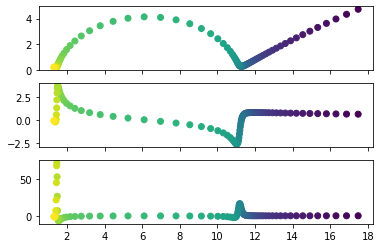

In [158]:
rand_sample = eis_data.sample(1).iloc[0]
#rand_sample = eis_data.iloc[6445]
ders = nth_derivatives(rand_sample["Z_real"], rand_sample["Z_imag"], 2)
plot_derivatives(rand_sample["Z_real"], ders, rand_sample["freq"])

In [159]:
find_stationary_points(rand_sample["Z_real"], ders)

[PointOfInterest(x=6.10661945, y=-4.13248497, kind='Minima'),
 PointOfInterest(x=11.26895687, y=-0.27171182, kind='Maxima'),
 PointOfInterest(x=1.42691248, y=-0.1890917, kind='Maxima')]

In [160]:
def find_zero_points(x: np.array, derivatives: list[np.array]) -> list[PointOfInterest]:
    assert len(x) == len(ders[0])
    zeros=[]
    funcs=[]
    for i, d in enumerate(derivatives):
        zeros.append([])
        signchange = (np.diff(np.sign(d)) != 0)*1
        idxs = np.nonzero(signchange)
        the_func = interpolate.interp1d(x, d)
        funcs.append(the_func)
        for idx in idxs[0]:
            sol = optimize.root_scalar(the_func, x0=x[idx], x1=x[idx+1])
            res = PointOfInterest(sol.root, funcs[0](sol.root)[()], kind=f"D{i}_Root")
            zeros[i].append(res)
        
    for i in range(1, len(derivatives)):
        next_der_func = funcs[i]
        for p in zeros[i-1]:
            next_der_sign = "+" if np.sign(next_der_func(p.x)) >= 1 else "-"
            p.kind = p.kind + f" NextDer({next_der_sign})"
    
    return list(itertools.chain(*zeros))

In [161]:
find_zero_points(rand_sample["Z_real"], ders)

[PointOfInterest(x=11.279616155316312, y=-0.27202105409239263, kind='D1_Root NextDer(-)'),
 PointOfInterest(x=6.290838046272267, y=-4.123041882797433, kind='D1_Root NextDer(+)'),
 PointOfInterest(x=1.4197800792408262, y=-0.1895591832455396, kind='D1_Root NextDer(-)'),
 PointOfInterest(x=11.985165399254543, y=-0.7675036878219399, kind='D2_Root'),
 PointOfInterest(x=11.028684265144518, y=-0.6716672087995502, kind='D2_Root'),
 PointOfInterest(x=1.515281162363414, y=-0.3912169762566202, kind='D2_Root'),
 PointOfInterest(x=1.3804754570733608, y=-0.19584733594608167, kind='D2_Root')]

In [162]:
def find_domain_extremes(x: np.array, derivatives:list[np.array]) -> list[PointOfInterest]:
    assert len(x) == len(ders[0])
    sorted_idxs = np.argsort(x)
    domain_min_idx = sorted_idxs[0]
    domian_max_idx = sorted_idxs[-1]
    return [
        PointOfInterest(x[domain_min_idx], derivatives[0][domain_min_idx], "Domain_min"),
        PointOfInterest(x[domian_max_idx], derivatives[0][domian_max_idx], "Domain_max")
    ]

['Domain_min', 'D2_Root', 'D1_Root NextDer(-)', 'D2_Root', 'D1_Root NextDer(+)', 'D2_Root', 'D1_Root NextDer(-)', 'D2_Root', 'Domain_max']


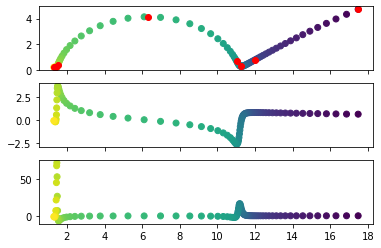

In [163]:
interesting_points = find_zero_points(rand_sample["Z_real"], ders) + find_domain_extremes(rand_sample["Z_real"], ders)
interesting_points = sorted(interesting_points, key=lambda p: p.x)
kinds = [p.kind for p in interesting_points]
print(kinds)
#print(interesting_points)
plot_derivatives(
    rand_sample["Z_real"],
    ders,
    rand_sample["freq"],
    interesting_points=interesting_points
)